## Feature selection

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
pics = './pics'
tables = './tables'

In [3]:
new_df = pd.read_csv(f'{tables}/all_desc.csv')

In [4]:
new_df.isnull().values.any()

False

In [5]:
X = new_df.iloc[:,:-1]
y = new_df.label
y

0        1
1        1
2        1
3        1
4        1
        ..
34787    0
34788    0
34789    0
34790    0
34791    0
Name: label, Length: 34792, dtype: int64

### Filtering invariant (1.13.1.) and highly correlated features

In [6]:
from sklearn.feature_selection import VarianceThreshold

def filter_data(X):
    correlation_threshold = 0.9
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(~np.tril(np.ones(corr_matrix.shape)).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]

    column_names = X.columns
    X = X.drop(to_drop, axis=1)
    
    variance_threshold = 0.9
    sel = VarianceThreshold(threshold=(variance_threshold * (1 - variance_threshold)))
    X = sel.fit_transform(X)
    kept_features = sel.get_support(indices=True)
    X = pd.DataFrame(X, columns=column_names[kept_features])

    return X

X = filter_data(X)

In [7]:
from numpy import mean
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance

from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

import warnings

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
y_test.value_counts()

0    3170
1     310
Name: label, dtype: int64

### Feature selection using Random Forest Classifier

In [9]:
Rtree_clf = RandomForestClassifier()
Rtree_clf = Rtree_clf.fit(X_train,y_train)
model = SelectFromModel(Rtree_clf, prefit=True)
RF_tree_featuresTrain = X_train.loc[:, model.get_support()]
RF_tree_featuresTest = X_test.loc[:, model.get_support()]
warnings.filterwarnings('ignore')

importances = Rtree_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in Rtree_clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
indices.shape
indices = indices[:200]

In [10]:
print(len(importances[indices]))

117


In [ ]:
indices

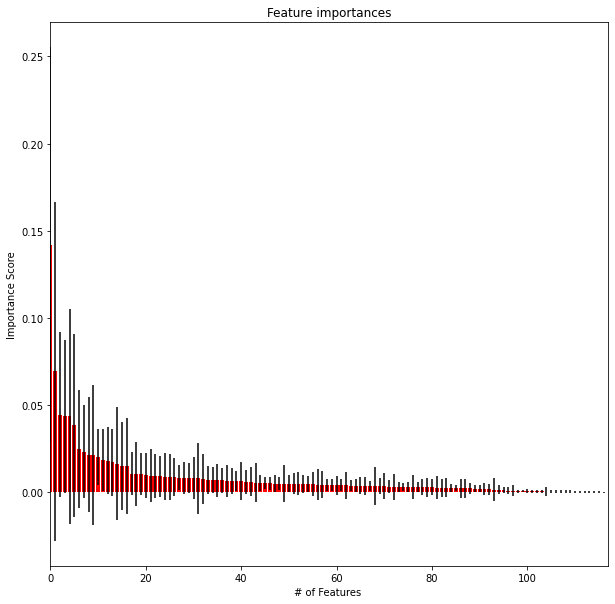

In [11]:
plt.figure(1, figsize=(10, 10))
plt.title("Feature importances")
plt.xlabel("# of Features ")
plt.ylabel("Importance Score")
plt.bar(range(len(importances[indices])), importances[indices], color="r", yerr=std[indices], align="center")
plt.xlim([0, len(importances[indices])])
# plt.show()
plt.savefig(f'{pics}/rf_feat_import.png')

### 1.13.3. Recursive Feature Elmination

In [12]:
from sklearn.feature_selection import RFECV, RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [13]:
clf = RandomForestClassifier(n_estimators=50, max_depth=10)
min_features_to_select = 20
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)

size = 6050
rfecv.fit(X[:size], y[:size])
print('Optimal number of features :', rfecv.n_features_)

Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Optimal number of features : 108


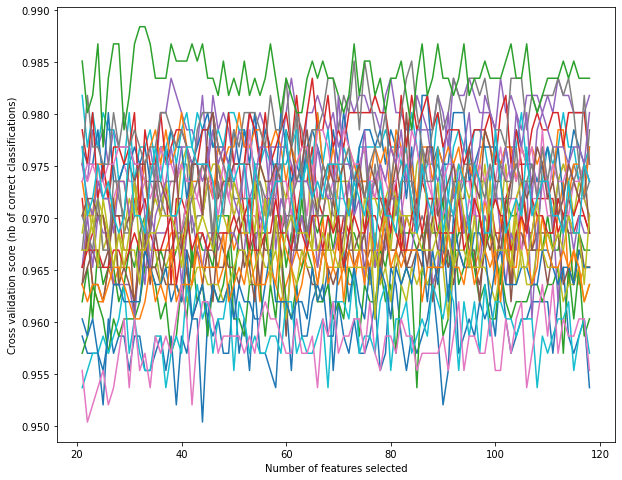

In [14]:
# Plot showing the Cross Validation score
fig, ax = plt.subplots(figsize=(10, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select + 1, min_features_to_select + len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
# plt.savefig(f'{pics}/rfecv_feat.png')

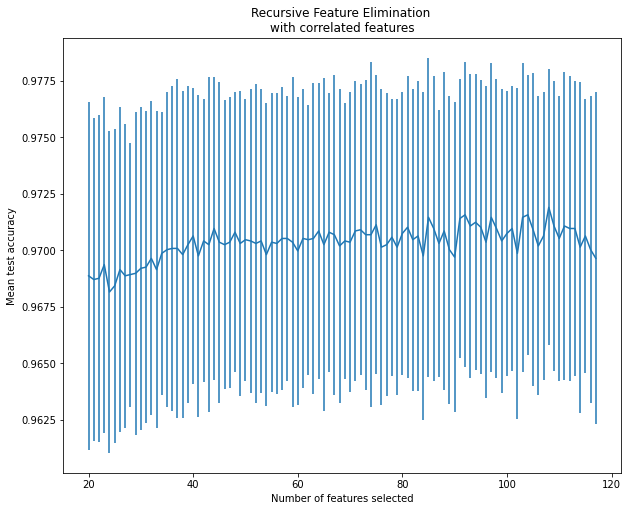

<Figure size 432x288 with 0 Axes>

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()
plt.savefig(f'{pics}/rfe_with_corr_feat.png')

### Applying RFE with optimal number of features found in RFECV

In [16]:
clf = RandomForestClassifier(n_estimators=50, max_depth=10)
rfe = RFE(estimator=clf, n_features_to_select=rfecv.n_features_, step=1)
rfe = rfe.fit(X_train, y_train)

In [17]:
rfe_train = pd.DataFrame(X_train).loc[:, rfe.get_support()]
rfe_test = pd.DataFrame(X_test).loc[:, rfe.get_support()]

print("Train Accuracy:",cross_val_score(clf,rfe_train,y_train, cv=5).mean())

clf = clf.fit(rfe_train, y_train)
y_pred = clf.predict(rfe_test)
print("Test Accuracy:", accuracy_score(y_pred, y_test))

print(classification_report(y_test, y_pred))

Train Accuracy: 0.9910258231068454
Test Accuracy: 0.9879310344827587


In [ ]:
rfe.get_support()

### Permutation importance

In [19]:
svc = svm.SVC(C=1, gamma=0.0001, random_state=0)
svc.fit(X_train, y_train)
perm_importance = permutation_importance(svc, X_test, y_test, n_jobs=-1)
features = np.array(X.columns)
sorted_idx = perm_importance.importances_mean.argsort()

#### Plot top 10 important features

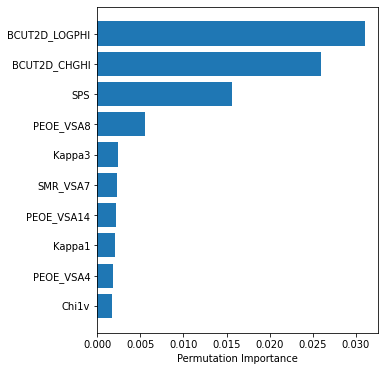

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.barh(features[sorted_idx][-10:], perm_importance.importances_mean[sorted_idx][-10:])
plt.xlabel("Permutation Importance")
plt.gcf().subplots_adjust(left=0.25)
plt.savefig(f'{pics}/top10_feat_perm.png')

#### Plot top 10 less important features

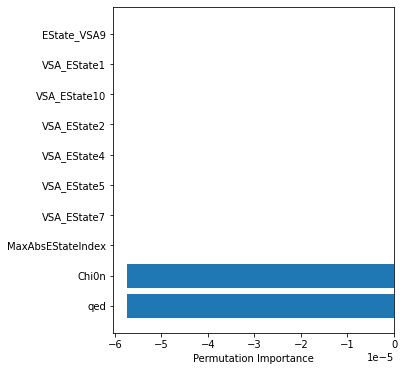

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.barh(features[sorted_idx][:10], perm_importance.importances_mean[sorted_idx][:10])
plt.xlabel("Permutation Importance")
plt.gcf().subplots_adjust(left=0.25)
plt.savefig(f'{pics}/top-10_feat_perm.png')

In [22]:
X

,MaxAbsEStateIndex,MinAbsEStateIndex,qed,SPS,NumRadicalElectrons,MaxPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,...,fr_alkyl_carbamate,fr_alkyl_halide,fr_aniline,fr_azide,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_hdrzine,fr_hdrzone
0,10.337455,-1.272753,23.375000,505.329,79.918731,10.123678,-2.326422,9.103951,-0.051090,3.459112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.335047,-1.271941,23.375000,505.329,79.918731,10.124302,-2.326422,9.103026,-0.051090,3.450909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.333078,-1.271281,23.375000,505.329,79.918731,10.124439,-2.326422,9.103025,-0.051090,3.448581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.355554,-1.235039,25.218750,440.504,16.562573,9.897992,-2.326488,5.825210,-0.051059,3.346646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.090409,0.226017,12.285714,362.614,79.918731,10.103988,-2.005563,9.101988,0.552888,3.020157,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34787,12.933117,-4.100987,14.468750,461.496,32.233273,10.184514,-2.413862,7.924364,-0.135518,3.193984,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
34788,5.666491,0.191419,19.187500,455.592,32.092047,10.229779,-2.513251,7.798553,0.113793,3.311255,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34789,13.336315,-3.927724,12.322581,451.432,32.233166,10.212402,-2.348322,7.920932,-0.387066,2.725871,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
34790,13.414551,-4.286701,25.687500,468.395,31.204928,9.953594,-2.599988,7.489276,-0.306706,2.803642,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Finding the number of dimensions to transform using PCA

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 5)
pca_traindata = pca.fit(X_train)

,MaxAbsEStateIndex,MinAbsEStateIndex,qed,SPS,NumRadicalElectrons,MaxPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,...,fr_alkyl_carbamate,fr_alkyl_halide,fr_aniline,fr_azide,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_hdrzine,fr_hdrzone
28288,12.717148,-0.591776,15.085714,492.963,35.495692,10.078008,-2.373845,6.438129,-0.119557,3.242167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20066,10.707298,-0.557387,12.333333,266.688,35.495692,10.097293,-2.118400,6.309494,-0.383520,2.707472,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29377,10.960836,-0.440765,11.111111,404.883,35.495692,10.165020,-2.225602,7.710048,-0.384486,2.973249,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9097,12.790502,-1.054762,17.444444,370.389,16.466854,10.073334,-2.714543,6.301088,-0.453813,3.172091,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
11127,12.530139,-3.424776,14.352941,488.634,32.233258,10.029155,-3.065542,7.916312,-0.890341,2.775803,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34001,10.332484,-1.436605,36.812500,460.480,16.572077,10.043971,-2.405989,5.714976,-0.077635,3.209869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24283,12.710392,0.047875,17.657143,480.589,16.518354,9.955738,-3.114775,5.781908,-0.920195,3.350810,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
18718,11.339319,-0.605915,15.000000,317.345,16.529760,10.143267,-3.057634,5.461785,-0.907619,2.717179,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3746,11.220451,-0.364727,24.705882,458.478,16.631681,9.878527,-2.835974,6.003918,-0.505362,3.403350,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
pcatrain = pca_traindata.transform(X_train)
pcatest = pca_traindata.transform(X_test)
cum_ratio = (np.cumsum(pca_traindata.explained_variance_ratio_))

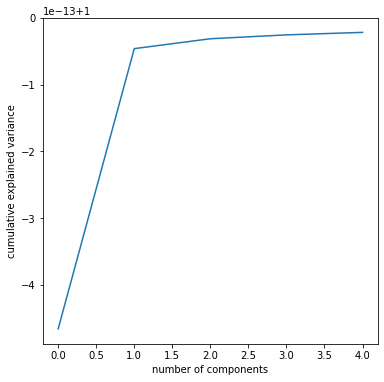

In [26]:

fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(cum_ratio)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()
# plt.savefig(f'{pics}/pca.png')

### Applying PCA with optimal number of features

In [27]:
pca = PCA(n_components = 100)
pca_traindata = pca.fit(X_train)

pcatrain = pca_traindata.transform(X_train)
pcatest = pca_traindata.transform(X_test)
(np.cumsum(pca_traindata.explained_variance_ratio_))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

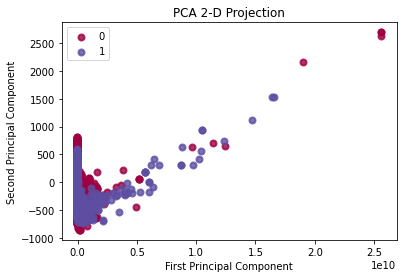

In [28]:
import scikitplot as skplt
skplt.decomposition.plot_pca_2d_projection(pca, X_train, y_train)
# plt.show()
plt.savefig(f'{pics}/pc1pc2_relat.png')

### Hierarchical clustering on the Spearman rank-order correlations

In [29]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

#### https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

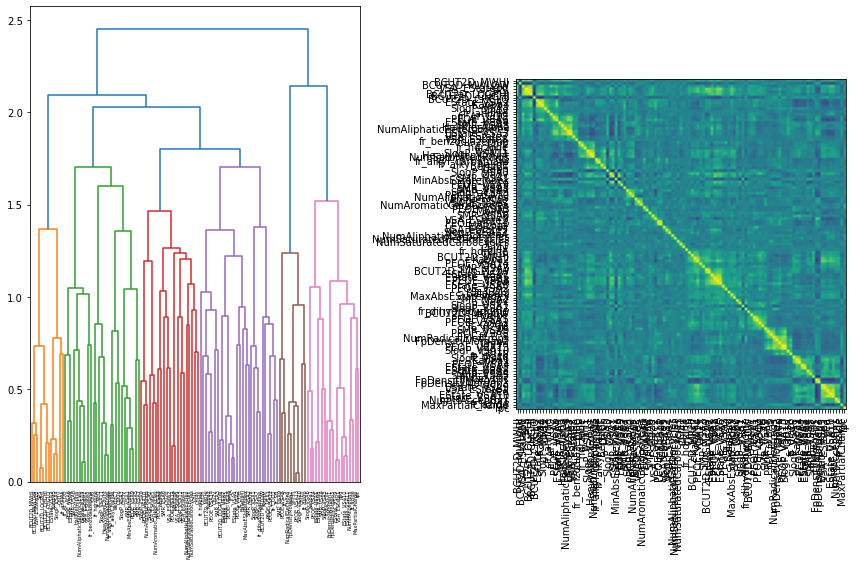

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

plt.savefig(f'{pics}/corr_hierarchy_spearmanr.png')

In [31]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_sel.score(X_test_sel, y_test):.2}"
)

Baseline accuracy on test data with features removed: 0.99


NameError: name 'plot_permutation_importance' is not defined

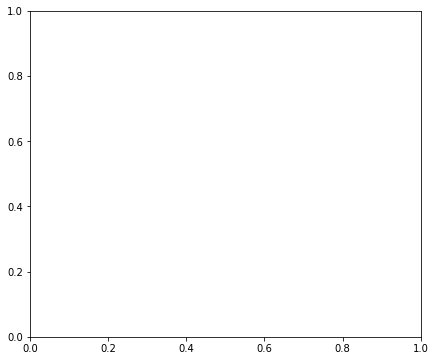

In [32]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
# plt.show()
plt.savefig(f'{pics}/perm_imp.png')